In [1]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.datasets import load_breast_cancer

In [2]:
x, y = load_breast_cancer(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

### Tuning parameters

In [3]:
parameter_grid = {
    "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "gamma": (0.5, 5),
    "subsample": (0.6, 1.0),
    "colsample_bytree": (0.6, 1.0),
    "max_depth": [3, 4, 5],
}

xgb = XGBClassifier(
    learning_rate=0.02,
    n_estimators=50,
    objective="binary:logistic",
    nthread=10,
    tree_method="gpu_hist",
    use_label_encoder=False,
    eval_metric="mlogloss"
)

x_train_tune, x_test_tune, y_train_tune, y_test_tune = train_test_split(x_train, y_train, test_size=.2, random_state=29)

In [4]:
tune_search = TuneSearchCV(
    xgb,
    parameter_grid,
    use_gpu=True,
    search_optimization="bayesian",
    n_trials=10,
    early_stopping=False,
    max_iters=1,
    local_dir='.',
    return_train_score=True,
    verbose=1
)
tune_search.fit(x_train_tune, y_train_tune)

TuneSearchCV(early_stopping=False,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_c...
                      <class 'ray.tune.logger.CSVLogger'>],
             n_jobs=-1,
             param_distributions={'colsample_bytree': (0.6, 1.0),
                                  'gamma': (0.5, 5), 'max_depth': [3, 4, 5],
                                  'min_child_weight': [1,

In [5]:
print(tune_search.best_params_)

{'min_child_weight': 2, 'gamma': 3.448703504559024, 'subsample': 0.6312355636083927, 'colsample_bytree': 0.6771972135888006, 'max_depth': 4}


In [6]:
# best classifier
xgb = XGBClassifier(
    learning_rate=0.02,
    n_estimators=50,
    objective="binary:logistic",
    nthread=10,
    tree_method="gpu_hist",
    use_label_encoder=False,
    eval_metric="mlogloss",
    **tune_search.best_params_)
xgb.fit(x_train_tune, y_train_tune)
xgb.score(x_test_tune, y_test_tune)

0.9186046511627907

### Training local models

In [7]:
def tuning(learners, local_ds, theta):
    global_predictions = []
    for learner in learners:
        global_predictions.append(learner.predict(global_set_x))
    global_predictions = np.array(global_predictions)
    
    certain_global_x = []
    certain_global_predictions = []
    correct_count = 0
    for i in range(len(global_set_x)):
        tmp = np.zeros(n_classes)
        for pred in global_predictions[:, i]:
            tmp[pred] += 1
        if tmp.max() >= theta:
            certain_global_x.append(global_set_x[i])
            certain_global_predictions.append(np.argmax(tmp))
            if np.argmax(tmp) == global_set_y[i]:
                correct_count += 1
    print("Certain predictions amount", len(certain_global_predictions), "with correct in them", correct_count)
    
    learners = []
    acc = 0
    for i in range(n_learners):
        xgb = XGBClassifier(
            learning_rate=0.02,
            n_estimators=50,
            objective="binary:logistic",
            nthread=10,
            tree_method="gpu_hist",
            use_label_encoder=False,
            eval_metric="mlogloss",
            **tune_search.best_params_)
        if len(certain_global_x) > 0:
            local_X = np.vstack([local_set_x[i*local_ds:(i+1)*local_ds], certain_global_x])
            local_Y = np.hstack([local_set_y[i*local_ds:(i+1)*local_ds], certain_global_predictions])
        else:
            local_X = local_set_x[i*local_ds:(i+1)*local_ds]
            local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        xgb.fit(local_X, local_Y)
        acc += xgb.score(x_test, y_test)
        learners.append(xgb)
    #print("Average accuracy of local workers", acc/n_learners)
        
    return learners, acc/len(learners)

In [22]:
n_classes = len(np.unique(y_train))
# unlabeled examples
m = 200
global_set_x = x_train[:m]
global_set_y = y_train[:m]
# labeled examples
local_set_x = x_train[m:]
local_set_y = y_train[m:]
n = len(x_train) - m
n_learners = 5
theta = 4
local_ds = n//n_learners
print("Length of the local dataset", local_ds)

Length of the local dataset 45


In [20]:
learners = []
acc = 0
for i in range(n_learners):
    xgb = XGBClassifier(
        learning_rate=0.02,
        n_estimators=50,
        objective="binary:logistic",
        nthread=10,
        tree_method="gpu_hist",
        use_label_encoder=False,
        eval_metric="mlogloss",
        **tune_search.best_params_)
    local_X = local_set_x[i*local_ds:(i+1)*local_ds]
    local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
    #print(Counter(local_Y))
    xgb.fit(local_X, local_Y)
    acc += xgb.score(x_test, y_test)
    learners.append(xgb)
print("Average accuracy of local workers", acc/n_learners)

Average accuracy of local workers 0.9188811188811188


In [21]:
for i in range(10):
    learners, acc = tuning(learners, local_ds, theta)
    print(acc)

Certain predictions amount 239 with correct in them 223
0.9300699300699302
Certain predictions amount 247 with correct in them 226
0.9272727272727274
Certain predictions amount 245 with correct in them 225
0.911888111888112
Certain predictions amount 247 with correct in them 226
0.904895104895105
Certain predictions amount 250 with correct in them 224
0.9076923076923077
Certain predictions amount 250 with correct in them 224
0.9076923076923077
Certain predictions amount 250 with correct in them 224
0.9076923076923077
Certain predictions amount 250 with correct in them 224
0.9076923076923077
Certain predictions amount 250 with correct in them 224
0.9076923076923077
Certain predictions amount 250 with correct in them 224
0.9076923076923077


### Tuning local_ds

In [23]:
local_ds_options = [10, 20, 30, 40, 45]
accuracies = []
for local_ds in local_ds_options:
    print("Local dataset size", local_ds)
    accuracies.append([])
    learners = []
    acc = 0
    for i in range(n_learners):
        xgb = XGBClassifier(
            learning_rate=0.02,
            n_estimators=50,
            objective="binary:logistic",
            nthread=10,
            tree_method="gpu_hist",
            use_label_encoder=False,
            eval_metric="mlogloss",
            **tune_search.best_params_)
        local_X = local_set_x[i*local_ds:(i+1)*local_ds]
        local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        xgb.fit(local_X, local_Y)
        acc += xgb.score(x_test, y_test)
        learners.append(xgb)
    accuracies[-1].append(acc/len(learners))
    for i in range(5):
        learners, acc = tuning(learners, local_ds, theta)
        accuracies[-1].append(acc)

Local dataset size 10
Certain predictions amount 200 with correct in them 129
Certain predictions amount 200 with correct in them 129
Certain predictions amount 200 with correct in them 129
Certain predictions amount 200 with correct in them 129
Certain predictions amount 200 with correct in them 129
Local dataset size 20
Certain predictions amount 200 with correct in them 129
Certain predictions amount 200 with correct in them 129
Certain predictions amount 200 with correct in them 129
Certain predictions amount 200 with correct in them 129
Certain predictions amount 200 with correct in them 129
Local dataset size 30
Certain predictions amount 190 with correct in them 172
Certain predictions amount 196 with correct in them 176
Certain predictions amount 198 with correct in them 179
Certain predictions amount 198 with correct in them 178
Certain predictions amount 200 with correct in them 178
Local dataset size 40
Certain predictions amount 191 with correct in them 175
Certain predicti

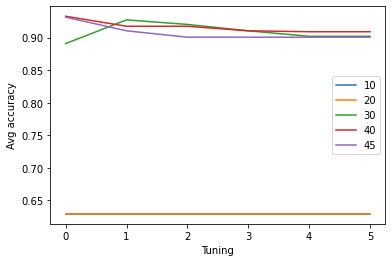

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

for ind, ld in enumerate(local_ds_options):
    accs = accuracies[ind]
    plt.plot(range(len(accs)), accs, label=str(ld))
plt.ylabel("Avg accuracy")
plt.xlabel("Tuning")
plt.legend()
plt.show()

### Tuning global ds

In [25]:
global_ds_options = [50, 100, 150, 200, 250, 300]
accuracies = []
for global_ds in global_ds_options:
    m = global_ds
    global_set_x = x_train[:m]
    global_set_y = y_train[:m]
    # labeled examples
    local_set_x = x_train[m:]
    local_set_y = y_train[m:]
    n = len(x_train) - m
    local_ds = n//n_learners
    print("Local dataset size", local_ds)
    accuracies.append([])
    learners = []
    acc = 0
    for i in range(n_learners):
        xgb = XGBClassifier(
            learning_rate=0.02,
            n_estimators=50,
            objective="binary:logistic",
            nthread=10,
            tree_method="gpu_hist",
            use_label_encoder=False,
            eval_metric="mlogloss",
            **tune_search.best_params_)
        local_X = local_set_x[i*local_ds:(i+1)*local_ds]
        local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        xgb.fit(local_X, local_Y)
        acc += xgb.score(x_test, y_test)
        learners.append(xgb)
    accuracies[-1].append(acc/len(learners))
    for i in range(5):
        learners, acc = tuning(learners, local_ds, theta)
        accuracies[-1].append(acc)

Local dataset size 75
Certain predictions amount 44 with correct in them 41
Certain predictions amount 45 with correct in them 42
Certain predictions amount 45 with correct in them 42
Certain predictions amount 45 with correct in them 42
Certain predictions amount 45 with correct in them 42
Local dataset size 65
Certain predictions amount 97 with correct in them 90
Certain predictions amount 98 with correct in them 90
Certain predictions amount 99 with correct in them 91
Certain predictions amount 99 with correct in them 90
Certain predictions amount 100 with correct in them 90
Local dataset size 55
Certain predictions amount 135 with correct in them 128
Certain predictions amount 145 with correct in them 135
Certain predictions amount 149 with correct in them 135
Certain predictions amount 149 with correct in them 135
Certain predictions amount 149 with correct in them 135
Local dataset size 45
Certain predictions amount 185 with correct in them 174
Certain predictions amount 198 with

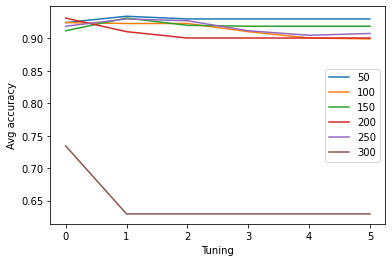

In [26]:
for ind, ld in enumerate(global_ds_options):
    accs = accuracies[ind]
    plt.plot(range(len(accs)), accs, label=str(ld))
plt.ylabel("Avg accuracy")
plt.xlabel("Tuning")
plt.legend()
plt.show()